# DICOM to D-NeRF converter

## Imports

In [10]:
import numpy as np
from pydicom import dcmread
import matplotlib.pyplot as plt
from PIL import Image
import os
import glm
import json
from tqdm import tqdm
import wfdb.processing


## DICOM conventions

The geometrical convention for the DICOM dataset is as follows:

* X is increasing toward the left 
* Y is increasing toward the back
* Z is increasing toward the head
* angle_cc = 0 is craniocaudal with incresing toward the head
* angle_rl = 0 is right-left with increasing toward the left
* Y is increasing toward the back
* Z is increasing toward the head

In [2]:
# Import sample dataset
ds = dcmread('sample_swing_01.dcm')
ds

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 194
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: X-Ray Angiographic Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.46.670589.29.447743807256521334348865060968091103083739030
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.38'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'SINGLE PLANE']
(0008, 0013) Instance Creation Time              TM: '083731.171'
(0008, 0016) SOP Class UID                       UI: X-Ray Angiographic Image Storage
(0008, 0018) SOP Instance UID                

In [3]:

print('\nSource to detector distance in mm (equivalent to focal length):')
print(ds['DistanceSourceToDetector'].value)


print('\nDetector size = [ImagerPixelSpacing x Rows, ColumnsImagerPixelSpacing x Columns] in mm:')
pixel_spacing = ds['ImagerPixelSpacing'].value
number_of_pixels = np.array([ds['Columns'].value, ds['Rows'].value])
print(pixel_spacing * number_of_pixels)

print('\nVertical field of view: fovy = 2 * atan(detector_size_y / 2 / DistanceSourceToDetector):')
fovy = 2 * np.arctan(pixel_spacing[1] * number_of_pixels[1] / 2 / ds['DistanceSourceToDetector'].value)
print(f"{fovy} radians")
print(f"{fovy * 180 / np.pi} degrees")

print('\nHorizontal field of view: fovx = 2 * atan(detector_size_x / 2 / DistanceSourceToDetector):')
fovx = 2 * np.arctan(pixel_spacing[0] * number_of_pixels[0] / 2 / ds['DistanceSourceToDetector'].value)
print(f"{fovx} radians")
print(f"{fovx * 180 / np.pi} degrees")



Source to detector distance in mm (equivalent to focal length):
1233

Detector size = [ImagerPixelSpacing x Rows, ColumnsImagerPixelSpacing x Columns] in mm:
[205.43998929 205.43998929]

Vertical field of view: fovy = 2 * atan(detector_size_y / 2 / DistanceSourceToDetector):
0.16623412884780797 radians
9.524513994013324 degrees

Horizontal field of view: fovx = 2 * atan(detector_size_x / 2 / DistanceSourceToDetector):
0.16623412884780797 radians
9.524513994013324 degrees


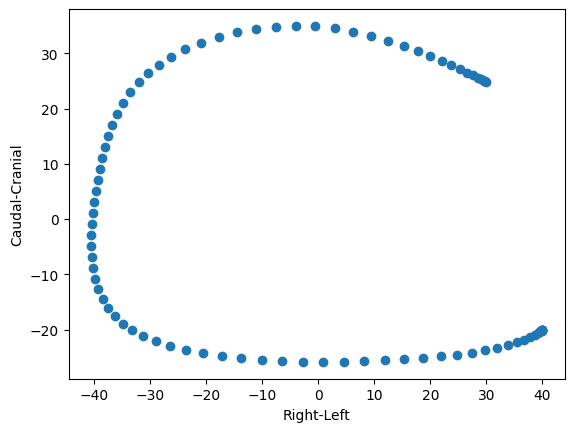

In [4]:
## Extract angualar data
rl_initial = ds[0x0018, 0x1510].value # Positioner Primary Angle
cc_initial = ds[0x0018, 0x1511].value # Positioner Secondary Angle

rl_array = ds[0x0018, 0x1520].value # Positioner Primary Angle Increment
cc_array = ds[0x0018, 0x1521].value # Positioner Secondary Angle Increment

# Add the initial angles to the increments to get the full angles
rl_array = [x + rl_initial for x in rl_array]
cc_array = [x + cc_initial for x in cc_array]


plt.scatter(rl_array,cc_array)
plt.xlabel('Right-Left')
plt.ylabel('Caudal-Cranial')
plt.show()


## Transformation matrix

In [5]:
# We now describe the camera model. In this case, we use the OpenGL convention (model, view, 
# projection matrices) as is done in NERF studio. The GLM library provides
# utilities to perform matrix multiplications specifically for this purpose.


# The isocenter is the origin of the coordinate system. The source is at [0, DistanceSourceToPatient, 0]


def calculate_transform_matrix(cc, rl, DistanceSourceToPatient):
    """
    Calculate the transform matrix for a camera in a medical imaging system.

    This function computes a 4x4 transformation matrix that represents the camera's
    position and orientation in 3D space, based on the craniocaudal and right-left
    angles, and the distance from the source to the patient.

    Args:
        cc (float): Craniocaudal angle in degrees.
        rl (float): Right-left angle in degrees.
        DistanceSourceToPatient (float): Distance from the X-ray source to the patient (isocenter) in cm.

    Returns:
        list: A 4x4 transformation matrix as a list of lists, representing the camera's
              position and orientation in the world coordinate system.
    """
    # Create rotation matrices for craniocaudal (cc) and right-left (rl) angles
    # Note: cc rotation is negated to match the coordinate system
    rot_cc = glm.rotate(glm.radians(-cc), glm.vec3(1,0,0))
    rot_rl = glm.rotate(glm.radians(rl), glm.vec3(0,0,1))

    # Calculate the source position by applying rotations to the initial position
    # Initial position is [0, DistanceSourceToPatient, 0]
    source_position = rot_rl*rot_cc*glm.vec3(0.0, DistanceSourceToPatient, 0.0)

    # Create a translation matrix to move the camera to the source position
    translation = glm.translate(source_position)

    # Create an image orientation matrix
    # This rotates the camera to face the correct direction
    # 180 degree rotation around Y-axis followed by -90 degree rotation around X-axis
    image_orientation = glm.rotate(glm.radians(180), glm.vec3(0,1,0))*glm.rotate(glm.radians(-90), glm.vec3(1,0,0))

    # Combine all transformations and convert to a 4x4 matrix
    # Order: translation * rotation_rl * rotation_cc * image_orientation
    return np.array((translation*rot_rl*rot_cc*image_orientation).to_list()).T.tolist()



transform_matrix = calculate_transform_matrix(-45,-45, ds['DistanceSourceToPatient'].value/100.0)
print(json.dumps(transform_matrix, indent=4))

[
    [
        -0.7071067690849304,
        -0.4999999403953552,
        0.4999999403953552,
        3.8249998092651367
    ],
    [
        0.7071066498756409,
        -0.5000000596046448,
        0.4999999403953552,
        3.8249998092651367
    ],
    [
        6.181723222198343e-08,
        0.7071067094802856,
        0.7071068286895752,
        5.409367084503174
    ],
    [
        0.0,
        0.0,
        0.0,
        1.0
    ]
]


## ECG analysis

We need to extract the ECG data from the DICOM file. This is done using the curve data in the DICOM file. We then use the ECG data to extract the time of the middle of each X-ray pulse. This allows us to gate the X-ray pulses to the ECG data.

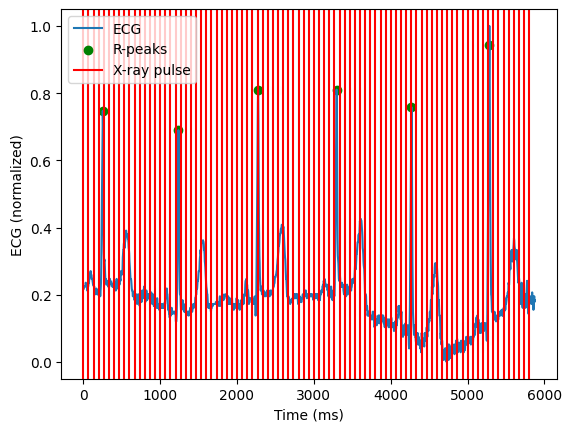

In [6]:
def extract_ecg_data(ds):
    frame_pulse_width = ds[0x0018, 0x1154].value  # Duration of X-ray emission for each frame
    number_of_frames = int(ds[0x0028, 0x0008].value)  # Total number of frames in the series
    frame_time_step = ds[0x0018, 0x1063].value  # Time between frames

    # Calculate the time of the middle of each X-ray pulse
    frame_time_data = np.linspace(0, frame_time_step * (number_of_frames - 1), number_of_frames) + frame_pulse_width/2

    # Extract ECG curve data
    # Based on https://dicom.nema.org/dicom/2004/04_03pu.pdf page 667

    # Determine the data type of the curve data
    curve_data_representation = ds[0x5000, 0x0103].value
    if curve_data_representation == 0:
        curve_data_type = np.uint16
    elif curve_data_representation == 1:
        curve_data_type = np.int16
    elif curve_data_representation == 2:
        curve_data_type = np.float16   
    elif curve_data_representation == 3:
        curve_data_type = np.float32
    elif curve_data_representation == 4:
        curve_data_type = np.int32  
        raise ValueError("Invalid curve data representation. Curve data VR should be unsigned short (US).")
    
    # Extract curve timing information
    curve_time_start = ds[0x5000,0x0112].value 
    curve_time_step = ds[0x5000,0x0114].value
    curve_x_axis_units = ds[0x5000,0x0030].value[0]

    # Convert DPPS (Digital Pulse Per Second) to milliseconds if necessary
    if curve_x_axis_units == 'DPPS':
        curve_time_start = 1000/ds[0x5000,0x0112].value 
        curve_time_step = 1000/ds[0x5000,0x0114].value

    # Extract curve data and metadata
    curve_length = ds[0x5000,0x0010].value
    curve_bytes = ds[0x5000,0x3000].value
    curve_min_value = ds[0x5000,0x0104].value
    curve_max_value = ds[0x5000,0x0105].value 

    # Convert bytes to array of appropriate data type
    curve_data = np.frombuffer(curve_bytes, dtype=np.uint16).astype(curve_data_type)

    # Normalize the curve data to the range [0, 1]
    curve_data = (np.abs(curve_data)-curve_min_value) / (curve_max_value-curve_min_value)

    # Generate time data for the curve
    curve_time_data = np.linspace(start=0, stop=curve_length-1, num=curve_length) * curve_time_step + curve_time_start

    # Detect R-peaks in the ECG curve
    r_peaks_indices = wfdb.processing.xqrs_detect(curve_data, fs=1000/curve_time_step, verbose=False)
    return curve_data, curve_time_data, curve_time_step, frame_time_data, frame_pulse_width, number_of_frames, frame_time_step, r_peaks_indices

def plot_ecg(ds, time_limits=None):
    """
    Plot the ECG curve and X-ray pulse timings from a DICOM dataset.

    This function extracts ECG curve data and X-ray pulse timing information from a DICOM dataset,
    normalizes the ECG data, and creates a plot showing the ECG curve with vertical lines
    indicating the timing of X-ray pulses.

    Parameters:
    -----------
    ds : pydicom.dataset.FileDataset
        A DICOM dataset containing ECG curve data and X-ray timing information.
    time_limits : tuple, optional
        A tuple of (start_time, end_time) in milliseconds to limit the x-axis of the plot.
        If None, the entire ECG curve will be displayed.

    Returns:
    --------
    None
        The function displays the plot using matplotlib.pyplot.show().

    Notes:
    ------
    - The function assumes specific DICOM tags are present in the dataset.
    - ECG data is normalized to the range [0, 1].
    - X-ray pulse timings are represented by red vertical lines.
    - The x-axis can be limited using the time_limits parameter for better visualization.
    - DICOM tag interpretations are based on the DICOM standard:
      https://dicom.nema.org/dicom/2004/04_03pu.pdf (page 667)
    """

    # Extract image frames time data
    curve_data, curve_time_data, _, frame_time_data, _, _, _, r_peaks_indices = extract_ecg_data(ds)

    # Plot the ECG curve
    plt.plot(curve_time_data, curve_data)

    # Plot R-peaks
    plt.scatter(curve_time_data[r_peaks_indices], curve_data[r_peaks_indices], color='g')

    # Add vertical lines for each X-ray pulse
    for frame_time in frame_time_data:
        plt.axvline(x=frame_time, color='r')


    # Set labels and legend
    plt.xlabel('Time (ms)')
    plt.ylabel('ECG (normalized)')
    plt.legend(['ECG','R-peaks', 'X-ray pulse'])
    if time_limits is not None:
        plt.xlim(time_limits)  # Set x-axis limit to 2000 ms
    plt.show()

# Call the function with the DICOM dataset
plot_ecg(ds)



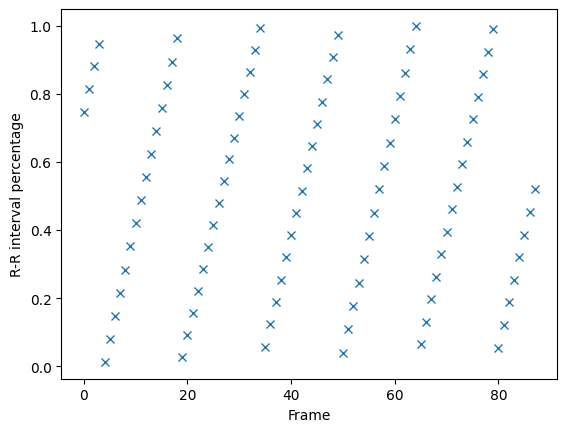

In [7]:
def calculate_RR_precentage_frame_times(ds):
    """
    Calculate the percentage of R-R interval for each frame in a DICOM dataset.

    This function extracts ECG data and frame timing information from a DICOM dataset,
    identifies R-peaks, and calculates the percentage of the R-R interval for each frame.

    Args:
        ds (pydicom.dataset.FileDataset): A DICOM dataset containing ECG and frame data.

    Returns:
        numpy.ndarray: An array of R-R interval percentages for each frame, normalized to [0, 1].

    Raises:
        ValueError: If there are not enough R-peaks to calculate R-R intervals.
    """
    # Extract ECG and frame data from the DICOM dataset
    curve_data, curve_time_data, curve_time_step, frame_time_data, frame_pulse_width, number_of_frames, frame_time_step, r_peaks_indices = extract_ecg_data(ds)

    # Extract time points of R-peaks
    rr_time_data = curve_time_data[r_peaks_indices]

    # Check if there are enough R-peaks to calculate intervals
    if len(rr_time_data) <= 1:
        raise ValueError("Not enough R-peaks to calculate RR intervals")

    # Interpolate frame times to get R-R percentage
    # Values outside the range of R-peaks are set to -2 (before first R-peak) or -1 (after last R-peak)
    frame_rr_percentage = np.interp(frame_time_data, rr_time_data, np.arange(0, rr_time_data.size*100, 100), left=-2, right=-1)

    # Calculate average R-R interval
    average_rr_interval = np.mean(np.diff(rr_time_data))

    # Handle frames before the first R-peak and after the last R-peak
    for idx, value in enumerate(frame_rr_percentage):
        if value == -2:  # Frame is before the first R-peak
            frame_rr_percentage[idx] = (frame_time_data[idx] - rr_time_data[0])/average_rr_interval*100
        if value == -1:  # Frame is after the last R-peak
            frame_rr_percentage[idx] = (frame_time_data[idx] - rr_time_data[-1])/average_rr_interval*100

    # Normalize percentages to [0, 1] range
    return (frame_rr_percentage % 100) / 100

# Plot the calculated R-R percentages
plt.plot(calculate_RR_precentage_frame_times(ds),'x')
plt.xlabel('Frame')
plt.ylabel('R-R interval percentage')
plt.show()
    

In [8]:
def create_nerf_dataset(ds, output_dir='output', scene_size_scale=1.0, undersampling_factor=1.0, flip_x=False):
    """
    Create a D-NeRF dataset from a DICOM series containing cine images.

    This function processes a DICOM series, extracts images and camera parameters,
    and generates a D-NeRF-compatible dataset with camera transformations.

    Args:
        ds (pydicom.dataset.FileDataset): The DICOM dataset.
        output_dir (str): Directory to save the output files. Default is 'output'.
        scene_size_scale (float): Scale factor for the scene size. Default is 1.0.
        undersampling_factor (float): Factor to undersample the frames. Default is 1.0.

    Returns:
        dict: A dictionary containing the D-NeRF dataset information.
    """

    # Calculate the horizontal field of view in radians
    distance_source_to_detector = ds['DistanceSourceToDetector'].value
    fovx = 2.0 * np.arctan(pixel_spacing[0] * number_of_pixels[0] / 2.0 / distance_source_to_detector)

    # Initialize the NeRF dataset dictionary
    nerf_dict = {
        "camera_angle_x": fovx,
        "frames": []
    }

    # Extract the number of frames from the DICOM file
    number_of_frames = int(ds[0x0028, 0x0008].value)

    # Extract initial angles and angle arrays
    rl_initial = ds[0x0018, 0x1510].value
    cc_initial = ds[0x0018, 0x1511].value
    rl_array = ds[0x0018, 0x1520].value
    cc_array = ds[0x0018, 0x1521].value

    # Adjust angles by adding initial values
    rl_array = [x + rl_initial for x in rl_array]
    cc_array = [x + cc_initial for x in cc_array]

    # Create a directory to store the images
    os.makedirs(os.path.join(output_dir, 'frames'), exist_ok=True)

    pixel_data = ds.pixel_array

    if pixel_data.shape[0] != number_of_frames:
        raise ValueError("The number of frames in the DICOM series does not match the number of frames in the pixel array.")
    if len(rl_array) != number_of_frames:
        raise ValueError("The number of frames in the DICOM series does not match the number of angles in the Positioner Primary Angle Increments.")
    if len(cc_array) != number_of_frames:
        raise ValueError("The number of frames in the DICOM series does not match the number of angles in the Positioner Secondary Angle Increments.")

    # Calculate the R-R percentage for each frame
    rr_percentage = calculate_RR_precentage_frame_times(ds)

    # Process each image in the DICOM series
    for idx, img_array in enumerate(tqdm(pixel_data)):
        # Skip frames based on undersampling factor
        if idx % undersampling_factor != 0:
            continue
        
        # Convert the image array to PIL Image and ensure RGB mode
        img = Image.fromarray(img_array)
        if img.mode != 'RGB':
            img = img.convert('RGB')
        
        if flip_x:
            img = img.transpose(method=Image.FLIP_LEFT_RIGHT)

        
        # Save the image as JPEG
        file_path = os.path.join('frames', f'frame_{idx:03d}.jpg')
        img.save(os.path.join(output_dir, file_path))

        # Calculate the transform matrix for this frame
        transform_matrix = calculate_transform_matrix(cc_array[idx], rl_array[idx], distance_source_to_detector * scene_size_scale)

        # Create a frame dictionary and add it to the NeRF dataset
        frame_dict = {
            "file_path": file_path,
            "rotation": 0.0,
            "time": rr_percentage[idx],
            "transform_matrix": transform_matrix
        }
        nerf_dict['frames'].append(frame_dict)
    
    # Save the NeRF dataset as a JSON file
    with open(os.path.join(output_dir, 'transforms.json'), 'w', encoding='utf-8') as f:
        json.dump(nerf_dict, f, ensure_ascii=False, indent=4)

    return nerf_dict

json_data = create_nerf_dataset(ds=ds, 
                                output_dir='test_output', 
                                scene_size_scale=0.01, 
                                undersampling_factor=6, 
                                flip_x=True)


100%|██████████| 88/88 [00:00<00:00, 4577.69it/s]
